# Hierarchical Clustering

In [5]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
import os
import pickle
from pprint import pprint
from os.path import join as JP
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

## Load Catalog

In [9]:
catalog = Catalog()
catalog = load_catalog(path=paths['catalog'], name='spacy_pipeline_on_US_corpus') # 15 documents
catalog = load_catalog(path=paths['catalog'], name='spacy_pipeline_on_EN_corpus') # 43 documents
print(len(catalog.documents))

15


## TFIDF

In [29]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
# TODO: Increase all these
EMBED_SIZE = 10000        
NUM_CLUSTERS = 4
WORDS_PER_CLUSTER = 0

In [31]:
vectorizer = TfidfVectorizer(
    min_df=.1,
    max_df=.7,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

In [32]:
_ = catalog.collect_corpus(attr='processed_text', form=list)

In [33]:
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

(15, 9936)


,0000,0000 process,0000 process produce,0011,0015,0018,0021,0023,0028,0031,...,yield loss,yield low,yield method,yield mol,yield reaction,zeolite,zeolite diatomaceous,zeolite diatomaceous earth,zinc,zirconium
0,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Clustering

In [34]:
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [35]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 6
CRITERION = 'maxclust'

In [36]:
from scripts.algorithms.clustering import (
    hca_document_clustering, 
    retrieve_hca_info,
    plot_dendogram_from_linkage_matrix)

In [37]:
Z = hca_document_clustering(tfidf, method='ward', distance_metric='cosine')
Z

[INFO]: Computing Distance Matrix using cosine distance
[INFO]: Performing Hierarchical Clustering using ward linkage


array([[ 3.   ,  8.   ,  0.503,  2.   ],
       [ 2.   , 11.   ,  0.504,  2.   ],
       [ 6.   ,  9.   ,  0.656,  2.   ],
       [ 0.   ,  7.   ,  0.789,  2.   ],
       [ 5.   , 14.   ,  0.803,  2.   ],
       [ 1.   ,  4.   ,  0.811,  2.   ],
       [16.   , 17.   ,  0.879,  4.   ],
       [12.   , 18.   ,  0.884,  3.   ],
       [10.   , 19.   ,  0.898,  3.   ],
       [13.   , 20.   ,  0.943,  3.   ],
       [21.   , 22.   ,  1.067,  7.   ],
       [23.   , 24.   ,  1.104,  6.   ],
       [15.   , 26.   ,  1.197,  8.   ],
       [25.   , 27.   ,  1.403, 15.   ]])

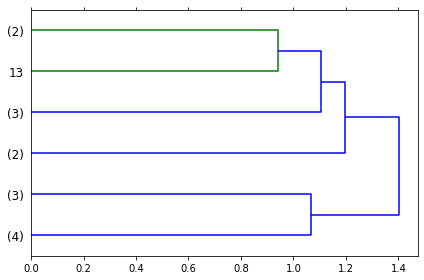

In [38]:
plot_dendogram_from_linkage_matrix(
    Z, truncate_mode='lastp', p=6, 
    show_leaf_counts=True, leaf_rotation=0.)

In [39]:
cluster_dict = retrieve_hca_info(Z, CRITERION, MIN_CLUSTERS, MAX_CLUSTERS)
pprint(cluster_dict)

defaultdict(<function retrieve_hca_info.<locals>.<lambda> at 0x1a25ed0d40>,
            {2: defaultdict(<class 'list'>,
                            {0: [[0, 2, 6, 7, 9, 11, 12]],
                             1: [[1, 3, 4, 5, 8, 10, 13, 14]]}),
             3: defaultdict(<class 'list'>,
                            {0: [[0, 2, 6, 7, 9, 11, 12]],
                             1: [[3, 8]],
                             2: [[1, 4, 5, 10, 13, 14]]}),
             4: defaultdict(<class 'list'>,
                            {0: [[0, 2, 6, 7, 9, 11, 12]],
                             1: [[3, 8]],
                             2: [[5, 10, 14]],
                             3: [[1, 4, 13]]}),
             5: defaultdict(<class 'list'>,
                            {0: [[2, 6, 9, 11]],
                             1: [[0, 7, 12]],
                             2: [[3, 8]],
                             3: [[5, 10, 14]],
                             4: [[1, 4, 13]]})})


## What are the important words? Map (dendogram --> treemap of words)
- Clustering labeling --> ICF?